# 1.0 Get Data Of Stock Market

* 本篇代码用来查询所有股票数据，所有导出的数据都将导出到stockdata文件夹内，方便管理查看。
* 平台api方面，国内用tushare，国外用的雅虎。
* 本篇代码也计划用来做数据清洗并且数据展示，处理好的文件也存在stockdata文件夹里面。

In [1]:
print("Hello,stock market")
from datetime import datetime
start_time = datetime.now()
import time
import numpy as np
## todo: calculating the time of import libraries
#先引入后面分析、可视化等可能用到的库
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
#正常显示画图时出现的中文和负号
from pylab import mpl
import yfinance as yf
import matplotlib.dates as mdates
import seaborn as sns
# todo: solve chinese problem for plt
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

#显示所有列
# pd.set_option('display.max_columns', 100)
# #显示所有行
# pd.set_option('display.max_rows', 100)
# #设置value的显示长度为100，默认为50
# pd.set_option('max_colwidth',100)
print("Load Time: ",datetime.now()-start_time)

Hello,stock market


D:\app\anaconda\envs\machineLearning\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (None)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


Load Time:  0:00:01.216848


## 1.1 use tushare api get data

In [2]:
# login tushare, use token
pro = ts.pro_api('f7b384108cbed0026a4dfa35835f75b0fb9d04673a067e8b75d8810f')


def getStockCompanyInformation(status='L', stock_code=''):
    """
    得到目前所有的股票公司信息
    :param status: 上市状态 L上市 D退市 P暂停上市，默认是L
    :param stock_code: TS股票代码
    :return:
    """

    if stock_code== '':
        rawStockCompanyDataInTushare = pro.stock_basic(exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')
    else:
        rawStockCompanyDataInTushare = pro.stock_basic(ts_code=stock_code, exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')

    rawStockCompanyDataInTushare['ts_code']=rawStockCompanyDataInTushare['ts_code'].astype(str)
    rawStockCompanyDataInTushare['symbol']=rawStockCompanyDataInTushare['symbol'].astype('float64')
    rawStockCompanyDataInTushare['name']=rawStockCompanyDataInTushare['name'].astype(str)
    rawStockCompanyDataInTushare['area']=rawStockCompanyDataInTushare['area'].astype(str)
    rawStockCompanyDataInTushare['industry']=rawStockCompanyDataInTushare['industry'].astype(str)
    rawStockCompanyDataInTushare['fullname']=rawStockCompanyDataInTushare['fullname'].astype(str)
    rawStockCompanyDataInTushare['enname']=rawStockCompanyDataInTushare['enname'].astype(str)
    rawStockCompanyDataInTushare['list_date']=rawStockCompanyDataInTushare['list_date'].astype('float64')

    rawStockCompanyDataInTushare['list_date']=pd.to_datetime(rawStockCompanyDataInTushare['list_date'], format='%Y%m%d')
    return rawStockCompanyDataInTushare


# 拉取数据
def getDailyStockData(stock_code="",start="20130101",end="20230101"):
    """
    拉取股票日结交易信息，时间段默认 2018-1-1 到 2022-1-1，注意：该函数单次只能查询6000条记录。
    :param stock_code: 股票代码，默认为空，输入为空的时候，拉取这段时期所有股票的交易消息；若不为空，拉去这只股票这段时间的交易消息
    :param start: 开始日期
    :param end: 结束日期
    :return:
    """
    rawData = pro.daily(**{
        "ts_code": stock_code,
        "trade_date": "",
        "start_date": start,
        "end_date": end,
        "offset": "",
        "limit": "",
    }, fields=[
        "ts_code",
        "trade_date",
        "open",
        "high",
        "low",
        "close",
        "pre_close",
        "change",
        "pct_chg",
        "vol",
        "amount"
    ])
    rawData['ts_code']=rawData['ts_code'].astype(str)
    rawData['trade_date']=rawData['trade_date'].astype('float64')

    rawData['trade_date']=pd.to_datetime(rawData['trade_date'], format='%Y%m%d')
    return rawData


In [3]:
rawCompanyDataInTushare=getStockCompanyInformation()
print("The shape of the data frame: {}".format(rawCompanyDataInTushare.shape))
print("The types in the data frame {}".format(rawCompanyDataInTushare.dtypes))
rawCompanyDataInTushare

The shape of the data frame: (5185, 8)
The types in the data frame ts_code              object
symbol              float64
name                 object
area                 object
industry             object
fullname             object
enname               object
list_date    datetime64[ns]
dtype: object


,ts_code,symbol,name,area,industry,fullname,enname,list_date
0,000996.SZ,996.0,*ST中期,北京,汽车服务,中国中期投资股份有限公司,"China CIFCO Investment Co.,Ltd",2000-07-18
1,002008.SZ,2008.0,大族激光,深圳,电器仪表,大族激光科技产业集团股份有限公司,"Han's Laser Technology Industry Group Co.,Ltd.",2004-06-25
2,002014.SZ,2014.0,永新股份,安徽,塑料,黄山永新股份有限公司,"Huangshan Novel Co.,Ltd",2004-07-08
3,002026.SZ,2026.0,山东威达,山东,机械基件,山东威达机械股份有限公司,"Shandong Weida Machinery Co.,Ltd.",2004-07-27
4,002033.SZ,2033.0,丽江股份,云南,旅游景点,丽江玉龙旅游股份有限公司,"Lijiang Yulong Tourism Co.,Ltd.",2004-08-25
...,...,...,...,...,...,...,...,...
5180,688552.SH,688552.0,C南湖,湖北,通信设备,航天南湖电子信息技术股份有限公司,Aerospace Nanhu Electronic Information Technol...,2023-05-18
5181,688515.SH,688515.0,裕太微-U,江苏,半导体,裕太微电子股份有限公司,"Motorcomm Electronic Technology Co., Ltd.",2023-02-10
5182,872541.BJ,872541.0,铁大科技,None,None,上海铁大电信科技股份有限公司,Shanghai Tieda Electronic and Information Tech...,2023-03-10
5183,833075.BJ,833075.0,柏星龙,None,None,深圳市柏星龙创意包装股份有限公司,"Shenzhen Baixinglong Creative Packaging Co., Ltd",2022-12-14


In [4]:
rawDailyDataInTushare=getDailyStockData()
print("The shape of the data frame: {}".format(rawDailyDataInTushare.shape))
print("The types in the data frame:\n{}".format(rawDailyDataInTushare.dtypes))
print("The unique stock code: {}".format(len(rawDailyDataInTushare['ts_code'].unique())))
rawDailyDataInTushare

The shape of the data frame: (6000, 11)
The types in the data frame:
ts_code               object
trade_date    datetime64[ns]
open                 float64
high                 float64
low                  float64
close                float64
pre_close            float64
change               float64
pct_chg              float64
vol                  float64
amount               float64
dtype: object
The unique stock code: 5061


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002198.SZ,2022-12-30,6.39,6.57,6.33,6.52,6.40,0.12,1.8750,101579.12,65646.164
1,002199.SZ,2022-12-30,6.36,6.43,6.28,6.39,6.29,0.10,1.5898,38684.00,24640.014
2,002194.SZ,2022-12-30,9.13,9.26,9.07,9.21,9.10,0.11,1.2088,101101.41,92895.425
3,002181.SZ,2022-12-30,5.28,5.52,5.28,5.46,5.31,0.15,2.8249,547665.70,297495.407
4,002195.SZ,2022-12-30,1.99,2.02,1.98,2.01,1.98,0.03,1.5152,444728.72,89088.620
...,...,...,...,...,...,...,...,...,...,...,...
5995,300185.SZ,2022-12-29,2.43,2.43,2.38,2.39,2.43,-0.04,-1.6461,169697.00,40744.559
5996,002212.SZ,2022-12-29,9.51,9.93,9.48,9.85,9.59,0.26,2.7112,166568.42,163068.690
5997,002213.SZ,2022-12-29,16.37,16.37,15.61,15.68,14.88,0.80,5.3763,238641.86,386408.221
5998,002397.SZ,2022-12-29,4.54,4.67,4.51,4.54,4.60,-0.06,-1.3043,127870.79,58483.435


In [5]:
##test
testDailyStockData=getDailyStockData(stock_code="000006.SZ")
testDailyStockData

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000006.SZ,2022-12-30,6.29,6.46,6.21,6.30,6.13,0.17,2.7732,1280164.06,8.071626e+05
1,000006.SZ,2022-12-29,6.60,6.65,6.13,6.13,6.81,-0.68,-9.9853,2067778.94,1.305957e+06
2,000006.SZ,2022-12-28,6.47,7.17,6.40,6.81,6.64,0.17,2.5602,2646897.32,1.789639e+06
3,000006.SZ,2022-12-27,6.00,6.64,5.96,6.64,6.04,0.60,9.9338,2469265.08,1.612829e+06
4,000006.SZ,2022-12-26,5.69,6.18,5.65,6.04,5.91,0.13,2.1997,1502166.93,8.940131e+05
...,...,...,...,...,...,...,...,...,...,...,...
2308,000006.SZ,2013-01-10,5.02,5.12,4.99,5.06,5.01,0.05,1.0000,231290.95,1.167205e+05
2309,000006.SZ,2013-01-09,5.02,5.07,4.95,5.01,5.08,-0.07,-1.3800,218039.31,1.094010e+05
2310,000006.SZ,2013-01-08,5.15,5.30,5.01,5.08,4.92,0.16,3.2500,472007.79,2.412159e+05
2311,000006.SZ,2013-01-07,4.90,4.94,4.82,4.92,4.93,-0.01,-0.2000,132315.27,6.452564e+04


In [6]:
###由于Toshare社区限制每次查询只能拿到 6000 行日结交易信息（每日每公司为一行），而且每分钟只能查500次。为了得到当前所有上市公司，每次查询只查一家上市公司而且将会延迟0.2秒
def bindDailyAndCompanyInformation():
    notIncludedData=['name']

    startTime=datetime.now()
    companies=getStockCompanyInformation()
    bindData=pd.DataFrame()
    i=2
    for company in companies['ts_code'].to_numpy():
        dailyData=getDailyStockData(stock_code=company)
        for header in companies.columns:
            if header!="ts_code":
                #test only
                # print("------------------------------------")
                # print(companies[companies['ts_code'] == company][header].values.repeat(5))
                # print(dailyData.shape[0])
                # print("------------------------------------")
                dailyData[header]= companies[companies['ts_code'] == company][header].values.repeat(dailyData.shape[0])

        dailyData=dailyData.drop(columns=notIncludedData)
        bindData=bindData.append(dailyData)
        #time.sleep(0.15)
        ###########test only
        #print(dailyData)
        # if i==1:
        #     break
        # else:
        #     i-=1
        ###########
    timeConsume=datetime.now()-startTime
    print("Run time: {}".format(timeConsume))
    return bindData


In [7]:
###此cell仅用于下载股票数据，由于信息量庞大，可导入下好的 TushareRawData.csv 文件即可
# theBindDataInTushare=bindDailyAndCompanyInformation()
# print("The shape of the data frame: {}".format(theBindDataInTushare.shape))
# print("The types in the data frame:\n{}".format(theBindDataInTushare.dtypes))
# print("The unique stock code: {}".format(len(theBindDataInTushare['ts_code'].unique())))
# theBindDataInTushare.to_csv('stockData/TushareRawData.csv', header=theBindDataInTushare.columns, index=False)

In [8]:
###此cell是本地读取tushare股票信息，如果本地有csv文件就用这个，并且注释上一个cell，如果没下载csv文件就取消注释上一个cell
theBindDataInTushare=pd.read_csv('stockData/TushareRawData.csv')
print("The shape of the data frame: {}".format(theBindDataInTushare.shape))
print("The types in the data frame:\n{}".format(theBindDataInTushare.dtypes))
print("The unique stock code: {}".format(len(theBindDataInTushare['ts_code'].unique())))

The shape of the data frame: (7792078, 17)
The types in the data frame:
ts_code        object
trade_date     object
open          float64
high          float64
low           float64
close         float64
pre_close     float64
change        float64
pct_chg       float64
vol           float64
amount        float64
symbol        float64
area           object
industry       object
fullname       object
enname         object
list_date      object
dtype: object
The unique stock code: 5061


In [9]:
###todo 不知道为什么有100家公司查不到，手动查询看看情况，然后手动合并吧
missedCompany=[]
bindCompany=theBindDataInTushare['ts_code'].unique()
for code in rawCompanyDataInTushare['ts_code'].values:
    if code not in bindCompany:
        missedCompany.append(code)


# for code in missedCompany:
#     print("-------------------------------------")
#     print(getDailyStockData(stock_code=code,end="20220505"))
#     print(getStockCompanyInformation(stock_code=code))
#     print("-------------------------------------")

print("The num of miss company: {}".format(len(missedCompany)))

###todo 这些股票查不到，这些公司基本都是2023年上市的，可能数据还没更新吧

The num of miss company: 124


In [10]:
print("The number of industry: {}".format(len(theBindDataInTushare['industry'].unique())))
print("The exact number of company: {}".format(len(theBindDataInTushare['ts_code'].unique())))
# print("--------------------------------------------------------\n"+"The industries: {}".format(theBindDataInTushare['industry'].unique()))

theCounter={}
uniqueList=rawCompanyDataInTushare['industry'].values
for industry in uniqueList:
    if industry in theCounter:
        theCounter[industry]+=1
    else:
        theCounter[industry]=1
theCounter=sorted(theCounter.items(), key = lambda kv:kv[1],reverse=True)
print("--------------------------------------------------------\n"+"the number of company in different industry:\n {}".format(theCounter))

The number of industry: 111
The exact number of company: 5061
--------------------------------------------------------
the number of company in different industry:
 [('None', 397), ('软件服务', 270), ('电气设备', 270), ('元器件', 259), ('化工原料', 225), ('专用机械', 217), ('汽车配件', 191), ('医疗保健', 163), ('半导体', 145), ('化学制药', 135), ('通信设备', 132), ('环境保护', 119), ('建筑工程', 111), ('机械基件', 104), ('电器仪表', 88), ('食品', 83), ('互联网', 83), ('家用电器', 77), ('中成药', 69), ('生物制药', 66), ('服饰', 64), ('家居用品', 63), ('塑料', 62), ('小金属', 53), ('仓储物流', 51), ('农药化肥', 50), ('证券', 50), ('纺织', 48), ('文教休闲', 48), ('广告包装', 47), ('航空', 45), ('IT设备', 45), ('区域地产', 44), ('影视音像', 42), ('运输设备', 42), ('银行', 41), ('农业综合', 41), ('供气供热', 37), ('医药商业', 34), ('百货', 33), ('矿物制品', 31), ('铝', 31), ('其他建材', 30), ('造纸', 30), ('装修装饰', 30), ('染料涂料', 30), ('出版业', 28), ('化纤', 27), ('普钢', 26), ('火力发电', 26), ('全国地产', 25), ('工程机械', 25), ('煤炭开采', 24), ('钢加工', 21), ('水泥', 21), ('机床制造', 21), ('多元金融', 21), ('汽车整车', 20), ('乳制品', 20), ('石油开采', 20), ('新型电力', 18), (

### test science data

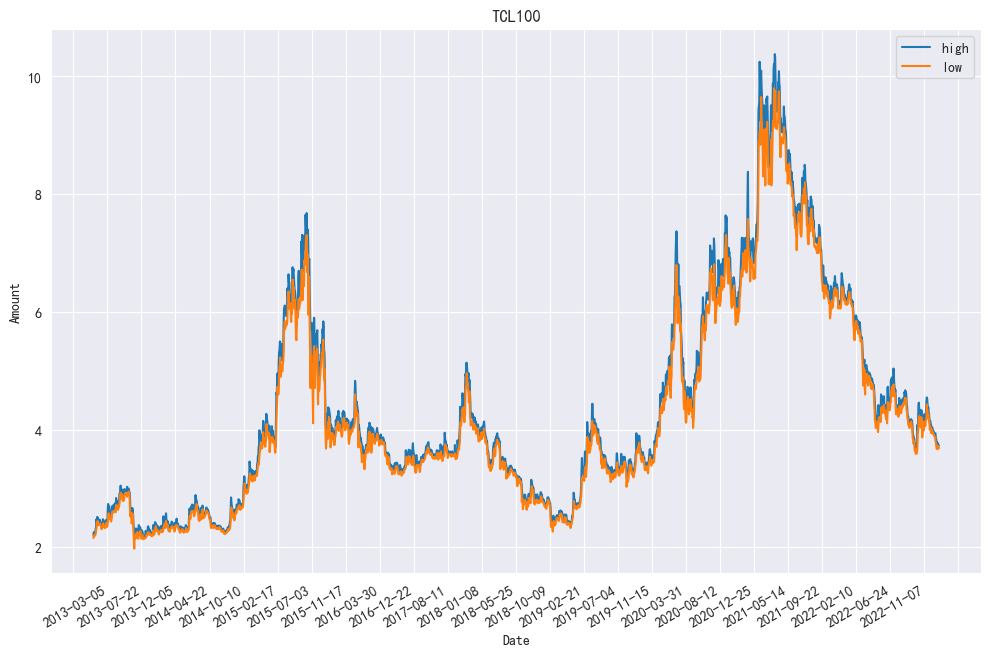

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,symbol,area,industry,fullname,enname,list_date
134489,000100.SZ,2013-01-04,2.20,2.21,2.16,2.21,2.19,0.02,0.9100,1603589.32,350309.8057,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134488,000100.SZ,2013-01-07,2.21,2.26,2.20,2.25,2.21,0.04,1.8100,2446465.65,548610.2820,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134487,000100.SZ,2013-01-08,2.25,2.25,2.21,2.24,2.25,-0.01,-0.4400,1223850.55,273030.6377,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134486,000100.SZ,2013-01-09,2.23,2.24,2.20,2.22,2.24,-0.02,-0.8900,1173131.58,260120.9124,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134485,000100.SZ,2013-01-10,2.22,2.23,2.20,2.22,2.22,0.00,0.0000,805958.97,178699.0808,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132257,000100.SZ,2022-12-26,3.72,3.76,3.72,3.75,3.73,0.02,0.5362,533547.21,199601.1210,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
132256,000100.SZ,2022-12-27,3.76,3.77,3.73,3.75,3.75,0.00,0.0000,514072.58,192359.1930,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
132255,000100.SZ,2022-12-28,3.75,3.76,3.71,3.73,3.75,-0.02,-0.5333,690095.26,257697.4930,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
132254,000100.SZ,2022-12-29,3.72,3.73,3.68,3.70,3.73,-0.03,-0.8043,839641.79,310683.4180,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30


In [11]:
TCLStock=theBindDataInTushare[theBindDataInTushare['ts_code']=="000100.SZ"].sort_values(by='trade_date',ascending=True)
plt.figure(figsize=(12,8))
ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.plot(TCLStock['trade_date'],TCLStock['high'],label="high")
plt.plot(TCLStock['trade_date'],TCLStock['low'],label="low")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title('TCL100')
plt.legend()   #打上标签
plt.show()
TCLStock

### 1.1.1 大盘整体趋势

In [12]:
theTrendResult=theBindDataInTushare.groupby('trade_date')['close','open'].mean()

plt.figure(figsize=(16,8))
ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.plot(theTrendResult['open'],label="open")
plt.plot(theTrendResult['close'],label="close")
plt.xlabel("Date")
plt.ylabel("Amount (RMB)")
plt.title('The Trend')
plt.legend()   #打上标签
plt.show()

theTrendResult

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

### 1.1.2 各个行业领域大盘

注意: 该cell运行会绘制大量的图表，图表都被保存好了，如果不想运行可以查看路径stockData/tableForIndustry/raw

In [ ]:
###生成各个领域的平均总览图标
#
# for i in list(theIndustryGroupedTrendResult):
#     plt.figure(figsize=(16,8))
#     x = np.arange(0, 300, 20)
#     plt.yticks(x)
#     i[-1]['close'].plot()
#     plt.xlabel("Date")
#     plt.ylabel("Amount (RMB)")
#     plt.title("The Industry Trend: {}".format(i[-1]['industry'].unique()[0]))
#     plt.legend()   #打上标签
#
#     ###下载图表
#     # plt.savefig("stockData/tableForIndustry/raw/industryTablesFor{}.jpg".format(format(i[-1]['industry'].unique()[0])))
#
# plt.show()
#
# theIndustryTrendResult

### 1.1.3 数据异常处理 (industry 为 none，建议优化)
注意: 行业总共110种，很多，在模型里面本身是建议降维的; 而且有些行业重复，例如金属被分成好几个领域，但是不建议归类，因为这些行业的走势都不一样，建议保留，等后续讨论。

目前计划拿到这些公司的产品与介绍，nle分析并将其分类到合适的种类

In [ ]:
### 目前已知的行业有110种，还有一种没有归类，现在尝试归类
print("the number of company with none industry: {}".format(len(theBindDataInTushare[theBindDataInTushare['industry'] == "None"]['ts_code'].unique())))


###查询行业缺失的公司简介与产品名称
# noneIndustryCodeList=theBindDataInTushare[theBindDataInTushare['industry'] == "None"]['ts_code'].unique()
# noneIndustryDF=pd.DataFrame()
# now=datetime.now()
# for code in noneIndustryCodeList:
#     ###该接口每分钟最多10次，尼玛得搞16分钟，之后会存在stockData/CompanyIntroductionWithNoneIndustry.csv
#     noneIndustrydf = pro.stock_company(ts_code=code, fields='ts_code,introduction,main_business')
#     noneIndustryDF=noneIndustryDF.append(noneIndustrydf)
#     time.sleep(6)
#
# noneIndustryDF.to_csv("stockData/CompanyIntroductionWithNoneIndustry.csv")
# print("cost time: {}".format(datetime.now()-now))



###查询行业已知的公司简介与产品名称
# knownIndustryCodeList=theBindDataInTushare[theBindDataInTushare['industry'] != "None"]['ts_code'].unique()
# knownIndustryDF=pd.DataFrame()
# now=datetime.now()
# for code in knownIndustryCodeList:
#     ###该接口每分钟最多10次，尼玛得搞16分钟，之后会存在stockData/CompanyIntroductionWithNoneIndustry.csv
#     knownIndustrydf = pro.stock_company(ts_code=code, fields='ts_code,introduction,main_business')
#     knownIndustryDF=knownIndustryDF.append(knownIndustrydf)
#     time.sleep(6)
#
# knownIndustryDF.to_csv("stockData/CompanyIntroductionWithKnownIndustry.csv")
# print("cost time: {}".format(datetime.now()-now))


noneIndustryDF=pd.read_csv("stockData/CompanyIntroductionWithNoneIndustry.csv")

knownIndustryDF=pd.read_csv("stockData/CompanyIntroductionWithKnownIndustry.csv")

In [ ]:
noneIndustryDF['industry']=noneIndustryDF.apply(lambda x:rawCompanyDataInTushare[x['ts_code']==rawCompanyDataInTushare['ts_code']]['industry'].values[0],axis=1)
noneIndustryDF

In [ ]:
knownIndustryDF['industry']=knownIndustryDF.apply(lambda x:rawCompanyDataInTushare[x['ts_code']==rawCompanyDataInTushare['ts_code']]['industry'].values[0],axis=1)
knownIndustryDF=knownIndustryDF[knownIndustryDF['industry']!='None']
print("行业数量（不包括None）: {}\n行业:{}".format(len(knownIndustryDF['industry'].unique()),knownIndustryDF['industry'].unique()))
knownIndustryDF

In [ ]:
###分词
import jieba
import re

def getStopWords(url):
    with open("NLP/stopwords/hit_stopwords.txt",'r',encoding='utf8') as f:
        stopword = f.readlines()
    return [i.replace('\n','') for i in stopword]

def tokenizPara(text,stopword):
    sentences=re.split('，|_|-|!|。|, ',text.strip())
    cutSentences=[]

    for sentence in sentences:
        ex="///".join(jieba.lcut(sentence))
        cutSentences+=ex.split('///')

    afterStop=list(set(cutSentences).difference(set(stopword)))
    afterStop=[i for i in afterStop if len(i)>1 and not i.isdigit()]
    return afterStop

###加载stopword
cn_stopwords=getStopWords("NLP/stopwords/cn_stopwords.txt")
baidu_stopword=getStopWords("NLP/stopwords/baidu_stopwords.txt")
hit_stopword=getStopWords("NLP/stopwords/hit_stopwords.txt")
scu_stopword=getStopWords("NLP/stopwords/scu_stopwords.txt")
myStopword=['一家','']
stopword_list=cn_stopwords+hit_stopword+baidu_stopword+scu_stopword+myStopword


unknownIndustryParagraphs=[]
for item in noneIndustryDF.values:
    tokens=tokenizPara(item[2],stopword_list)
    unknownIndustryParagraphs.append(tokens)

knownIndustryParagraphs=[]
for item in knownIndustryDF.values:
    tokens=tokenizPara(item[2],stopword_list)
    knownIndustryParagraphs.append(tokens)


# print("------------------------------------\n"
#       "unknowIndustry:\n{}"
#       "\n------------------------------------\n"
#       "knowIndustry:\n{}".format(unknownIndustryParagraphs[:3],knownIndustryParagraphs[:3]))

knownIndustryDF['keyword']=knownIndustryParagraphs
noneIndustryDF['keyword']=unknownIndustryParagraphs
###根据行业合并文本
AllIntroduction=[]
introductionByIndustry=pd.DataFrame()
for intro in list(knownIndustryDF.groupby('industry')):
    paras=[]
    for para in intro[1]['keyword'].values:
        paras+=para
        AllIntroduction+=para
    row={'industry':intro[0],'keywords':paras}
    introductionByIndustry=introductionByIndustry.append(row,ignore_index=True)

introductionByIndustry['cut_keywords']=introductionByIndustry.apply(lambda x:" ".join(x['keywords']), axis=1)

introductionByIndustry

In [ ]:
###todo 开始训练LDA模型


In [ ]:
###todo 验证


In [ ]:
### todo 泛化

## 1.2 use yfinance (雅虎非官方API) api get stock data

In [ ]:
#测试api
data = yf.download(tickers='AMD',start='2013-01-1',end='2023-01-01')
print("The types in the data frame:\n{}".format(data.dtypes))
data

In [ ]:
amd = yf.Ticker("AMD")
info=pd.DataFrame.from_dict(amd.info)
print("The types in the data frame:\n{}".format(info.dtypes))
info

In [ ]:
data["Close"].plot()
plt.show()

In [ ]:
##获取标普500股票公司名字
import bs4 as bs
import requests

###爬取维基百科标普500公司名称
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

###筛选元素
tickers = []
for row in table.findAll('tr')[1:]:
   ticker = row.findAll('td')[0].text
   ticker=ticker.replace("\n","")
   tickers.append(ticker)


tickers

In [ ]:
def getStockDataInYFinance(name,start='2013-01-1',end='2023-01-01'):
    includedList=['country','zip','industry','sector']
    data = yf.download(tickers=name,start=start,end=end)
    data['trade_date'] = data.index
    company = yf.Ticker(name)
    try:
        companyInfo=pd.DataFrame.from_dict(company.info)
    except BaseException:
        print(company.info)
        return np.nan
    else:
        data['name']=[name]*data.shape[0]
        for column in companyInfo.columns:
            if column in includedList:
                data[column]=np.array([companyInfo[column].values[0]]).repeat(data.shape[0])

    return data


### get all stock data and store them
def storeAllStockDataForYFinance():
    now=datetime.now()
    allStockDataInYFinance=pd.DataFrame()
    for company in tickers:
        companyInfo=getStockDataInYFinance(company)
        if companyInfo is np.nan:
            print("break, company {} data is null")
            continue
        else:
            allStockDataInYFinance=allStockDataInYFinance.append(companyInfo)
    print("Cost time: {}".format(datetime.now()-now))
    return allStockDataInYFinance

In [ ]:
getStockDataInYFinance(tickers[0]).dtypes

In [ ]:
###仅用于下载yfinance 股票数据
# stockDataInYFinance=storeAllStockDataForYFinance()
# stockDataInYFinance.to_csv('stockData/YFinanceRawData.csv', header=stockDataInYFinance.columns,index=False)

In [ ]:
###验证一下有多少个查漏了
stockDataInYFinance=pd.read_csv('stockData/YFinanceRawData.csv')
uniqueCompany=stockDataInYFinance['name'].unique()
missedList=[]
for ticker in tickers:
    if ticker not in uniqueCompany:
        missedList.append(ticker)

print("length of miss company: {}".format(len(missedList)))
###总共有3个公司遗漏

###手动查询
for company in missedList:
    print("------------------------------------------------------")
    print("This is the information for {}".format(company))
    print(getStockDataInYFinance(name=company))
    print("------------------------------------------------------")
###经过调查，属于信息不完善，有的连公司信息都不全

In [ ]:
print("types in data: {}".format(stockDataInYFinance.dtypes))
stockDataInYFinance

In [ ]:
MMMStock=stockDataInYFinance[stockDataInYFinance['name']=="MMM"]

plt.figure(figsize=(15,8))

ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)

x=MMMStock['trade_date']

plt.plot(x,MMMStock['High'],label="high")
plt.plot(x,MMMStock['Low'],label="low")
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title('MMM')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams.update({'font.size': 15})
plt.legend()   #打上标签
plt.show()
MMMStock

# 2.0 Analysis the raw data in AI
* data engineering
* data cleaning
* build model
* train

------------------------------------------
这里说一下训练集与验证集的分配:
* 训练集: 截取 2013-01-01 to 2018-01-01，5年数据，占总比50%。
* 验证集1: 截取 2018-01-01 to 2019-01-01 1年数据， 占总比10%，因为疫情就发生在2019年，该验证集用于检测模型准确度，确保该模型在疫情前时期可以正常使用
* 验证集2: 截取 2019-01-01 to 2023-01-01 4年数据，占比40%，该数据集并非用于验证，而是在确保验证集1能正常运行的情况下，用于观察疫情发生与正常预期是否有大偏差（验证是否疫情对股票市场有巨大影响）